In [1]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn

In [2]:
DEV = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEV)

cpu


In [54]:
class AdaptiveVectorNavigation():
    def __init__(self, 
                 forage_time: int, 
                 num_neurons: int,
                 leak_rate  : float) -> None:
        self.feeder_position = torch.randn((2,), device=DEV) # TODO: follow eqs 25, 26, 27
        self.time = 0
        self.forage_time = forage_time
        self.reward_threshold = 10 # TODO: make real value

        self.phi      = torch.zeros((1,), device=DEV)
#         print(f"phi: {self.phi}")
        self.speed    = 0
        self.state    = True # outward trip initially
        self.position = torch.zeros((2,), device=DEV) # (x,y)
        self.rewards  = 0
    
        self.neuron_phi            = (2 * torch.pi / num_neurons) * torch.arange(num_neurons, device=DEV)
        self.cosine_kernel         = torch.empty((num_neurons, num_neurons), device=DEV)
        for i in range(num_neurons):
            for j in range(num_neurons):
                self.cosine_kernel[i,j] = torch.cos(self.neuron_phi[i] - self.neuron_phi[j])
        self.decoding_layer           = torch.zeros((num_neurons,), device=DEV)
        self.previous_memory_layer    = torch.zeros((num_neurons,), device=DEV)
        self.leak_rate                = leak_rate
        self.home_vector              = torch.zeros((num_neurons,), device=DEV)
        self.global_vector            = torch.ones((num_neurons,), device=DEV)
        self.learning_rate            = 2 # mu = 2 by default. can change. 
        self.inverse_temp_exploration = 0.1 # guess at a good initial value
        self.lpf_food_reward          = torch.zeros((1,), device=DEV)
        
        self.relu = nn.ReLU()

    def update_home_vector(self) -> None:
        head_layer = torch.cos(self.phi - self.neuron_phi)
        gating_layer = self.relu(head_layer - 1 + self.speed)
        memory_layer = self.relu(gating_layer + ((1 - self.leak_rate) * self.previous_memory_layer))
        self.previous_memory_layer = memory_layer
        self.decoding_layer = self.relu(torch.matmul(self.cosine_kernel, memory_layer)) # actually the head vector
        self.head_vector_angle = torch.atan(torch.dot(self.decoding_layer, torch.sin(self.neuron_phi)) / torch.dot(self.decoding_layer, torch.cos(self.neuron_phi)))
        head_vector_length = torch.sum(self.decoding_layer) # could be incorrect implementation, hard to understand article
        self.motor_hv = head_vector_length * torch.sin(self.head_vector_angle - self.phi - torch.pi)

    def update_global_vector(self) -> None:
        global_layer = torch.cos(self.phi - self.neuron_phi)
#         print(f"global layer1: {global_layer}")
        self.state = (self.time < self.forage_time) and (self.rewards < self.reward_threshold) # inward/outward trip
        
        self.rewards = self.relu(1 - 5 * torch.norm(self.feeder_position - self.position))
#         print(f"rewards: {self.rewards}")
        global_layer = int(self.state) * self.global_vector
#         print(f"state: {self.state}")
#         print(f"global layer: {global_layer}")
        delta_global_vector = self.learning_rate * self.rewards * int(self.state) * (self.decoding_layer - global_layer) # equation 14 and 15. 
        self.global_vector += delta_global_vector 
        
        global_vector_angle = torch.atan(torch.dot(global_layer, torch.sin(self.neuron_phi)) / torch.dot(global_layer, torch.cos(self.neuron_phi)))
        global_vector_length = torch.sum(self.global_vector) # todo: unsure
#         print(f"global vec angle/length: {global_vector_angle, global_vector_length}")
        self.motor_gv = global_vector_length * torch.sin(global_vector_angle - self.phi) #todo: global vector angle?
        

        global_vector_length = torch.sum(self.global_vector) # todo: unsure
        global_vector_angle = torch.atan(torch.dot(self.global_vector, torch.sin(self.neuron_phi)) / torch.dot(self.global_vector, torch.cos(self.neuron_phi)))
        self.motor_gv = global_vector_length * torch.sin(global_vector_angle - self.phi) #todo: global vector angle?

    def update_navigation(self) -> None:
        # update sensory input
        # self.phi, self.speed, self.state, and self.rewards
        self.speed = 1 # TODO: make based on change in position over time
        
        self.update_home_vector()

        self.update_global_vector()

        # update exploration and navigation
        exploration_rate = int(self.state) * torch.exp(-self.inverse_temp_exploration * self.lpf_food_reward) #todo: equation 19
        random_search = torch.normal(0.0, exploration_rate)
        self.lpf_food_reward = self.rewards + 0.995 * self.lpf_food_reward
#         print(f"lpf food reward: {self.lpf_food_reward}")
        self.inverse_temp_exploration += 1e-6 * ((1 / self.inverse_temp_exploration) + (100 * self.lpf_food_reward * exploration_rate))
#         print(f"inverse temp of exploration {self.inverse_temp_exploration}")
        motor_command = (1 - exploration_rate) * ((int(self.state) * self.motor_gv) + self.motor_hv) + random_search
#         print(f"motor gv/hv: {self.motor_gv, self.motor_hv}")

        # update position due to control input
        if self.state:
            self.phi += 0.1 * torch.pi * motor_command # 0.1 = Delta t
            self.position[0] += torch.squeeze(0.1 * torch.cos(self.phi))
            self.position[1] += torch.squeeze(0.1 * torch.sin(self.phi))
        else:
            self.position[0] += torch.squeeze(0.1 * -torch.cos(self.head_vector_angle))
            self.position[1] += torch.squeeze(0.1 * -torch.sin(self.head_vector_angle))
        #         print(f"prodands: {self.lpf_food_reward, self.phi}")
        #         print(self.position[0])

        self.time += 1

In [55]:
graph_test_navigation = AdaptiveVectorNavigation(1000, 18, 0.05)

In [56]:
position_sequence = torch.empty((1200, 2), device=DEV)
position_sequence[0] = graph_test_navigation.position
for i in range(1199):
    graph_test_navigation.update_navigation()
    position_sequence[i+1] = graph_test_navigation.position
    if i % 100 == 0:
        print(f"done with time step {i+1}")

done with time step 1
done with time step 101
done with time step 201
done with time step 301
done with time step 401
done with time step 501
done with time step 601
done with time step 701
done with time step 801
done with time step 901
done with time step 1001
done with time step 1101


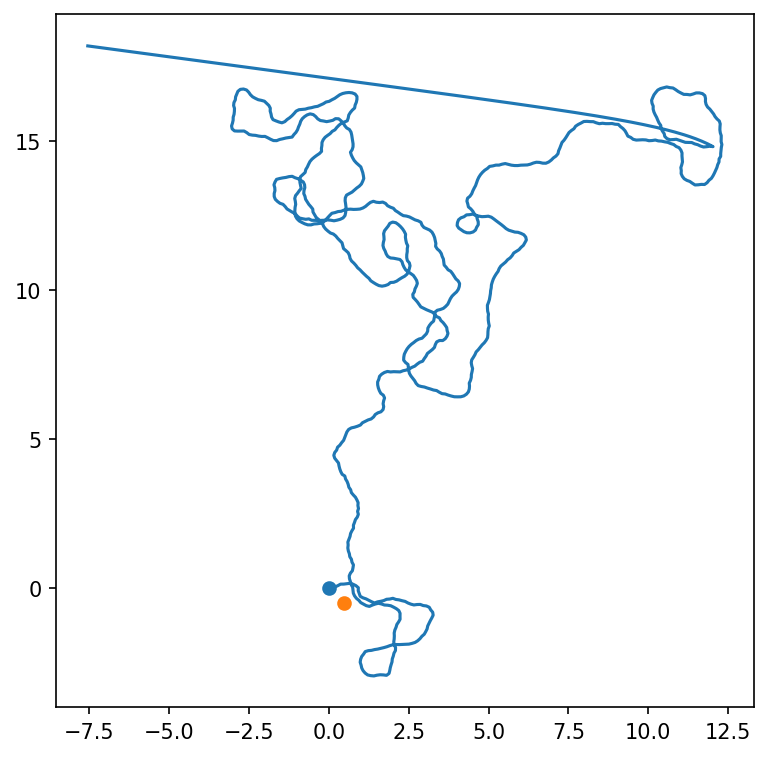

In [57]:
plt.figure(figsize=(6,6), dpi=150)
plt.plot(position_sequence[:,0], position_sequence[:,1])
plt.scatter(np.array([0]), np.array([0]))
plt.scatter(graph_test_navigation.feeder_position[0], graph_test_navigation.feeder_position[1])
plt.show()